## General information

In this kernel I'll try various technics for models interpretability and feature selection. Also I'll compare various models.

I use the features from my dataset: https://www.kaggle.com/artgor/lanl-features

This dataset was created using this kernel: https://www.kaggle.com/artgor/even-more-features/

**UPD**: Thanks to the new kaggle update we can write code in kernels and import it. This is much more convenient and useful.
I'm moving all the functions I can into this script: https://www.kaggle.com/artgor/artgor-utils
So if you see somewhere code like `artgot_utils.function_name(parameters)` - it is from this script

![](https://torontoseoulcialite.com/wp-content/uploads/2016/02/zimbiocom.jpg)

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import NearestNeighbors
import librosa, librosa.display
import builtins
from sklearn.ensemble import RandomForestRegressor
import eli5
import shap
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE

from IPython.display import HTML
import json
import altair as alt

import artgor_utils

# setting up altair
workaround = artgor_utils.prepare_altair()
HTML("".join((
    "<script>",
    workaround,
    "</script>",
)))

In [2]:
os.listdir('../input/lanl-features')

['test_features_denoised.csv',
 'submission_1.csv',
 'train_features_denoised.csv',
 'train_features.csv',
 'y.csv',
 'test_features.csv']

* 'train_features.csv' - train features generated on original data
* 'train_features_denoised.csv' - train features generated on denoised data
* 'test_features.csv' - test features generated on original data
* 'test_features_denoised.csv' - test features generated on denoised data
* 'submission_1.csv' - one of my local submissions
* 'y.csv' - train target

## Loading data
Let's load features!

In [3]:
train_features = pd.read_csv('../input/lanl-features/train_features.csv')
test_features = pd.read_csv('../input/lanl-features/test_features.csv')
train_features_denoised = pd.read_csv('../input/lanl-features/train_features_denoised.csv')
test_features_denoised = pd.read_csv('../input/lanl-features/test_features_denoised.csv')
train_features_denoised.columns = [f'{i}_denoised' for i in train_features_denoised.columns]
test_features_denoised.columns = [f'{i}_denoised' for i in test_features_denoised.columns]
y = pd.read_csv('../input/lanl-features/y.csv')

In [4]:
X = pd.concat([train_features, train_features_denoised], axis=1).drop(['seg_id_denoised', 'target_denoised'], axis=1)
X_test = pd.concat([test_features, test_features_denoised], axis=1).drop(['seg_id_denoised', 'target_denoised'], axis=1)
X = X[:-1]
y = y[:-1]

We have almost 2000 features here!

In [5]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

## Basic model

Training function is imported from my script. Important changes from the code, which I used previously:
- function returns dictionary with oof, test predictions and scores. Also with feature importances, if necessary;
- in future it will be easier to change metrics.

Fold 1 started at Sun May 12 16:54:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[467]	training's l1: 1.41639	valid_1's l1: 2.16578
Fold 2 started at Sun May 12 16:54:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[799]	training's l1: 1.13398	valid_1's l1: 1.99639
Fold 3 started at Sun May 12 16:54:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[870]	training's l1: 1.08087	valid_1's l1: 2.02497
Fold 4 started at Sun May 12 16:55:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[490]	training's l1: 1.4059	valid_1's l1: 1.9957
Fold 5 started at Sun May 12 16:55:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[515]	training's l1: 1.36423	valid_1's l1: 2.22303
Fold 6 started at Sun May 12 16:55:56 2019

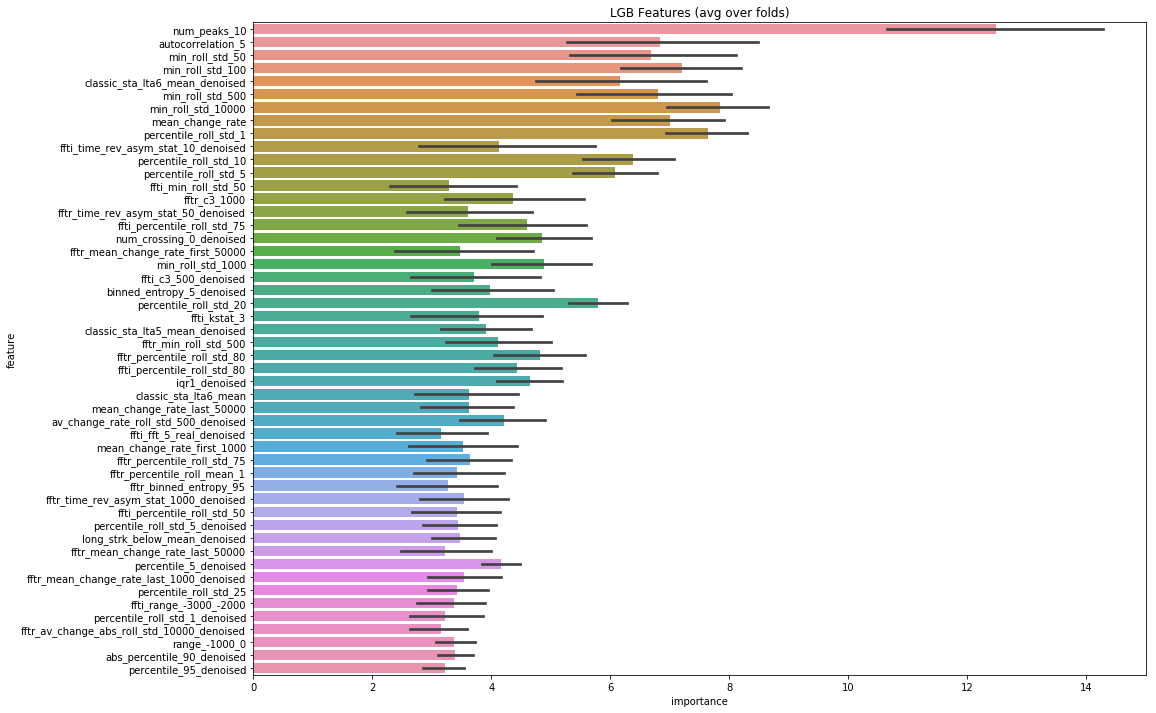

In [6]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "subsample_freq": 5,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'colsample_bytree': 0.1
         }
result_dict_lgb = artgor_utils.train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb',
                                                                                  eval_metric='mae', plot_feature_importance=True)

In [7]:
submission = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = result_dict_lgb['prediction']
print(submission.head())
submission.to_csv('submission.csv')

              time_to_failure
seg_id                       
seg_00030f  3.800789173472036
seg_0012b5  4.596608696690855
seg_00184e  5.445913938464765
seg_003339  8.469261605552141
seg_0042cc  7.011492646553842


In [8]:
sub1 = pd.read_csv('../input/lanl-features/submission_1.csv')
sub1.to_csv('submission_1.csv', index=False)

## NN features
Here I normalize the data and create features using NearestNeighbors. The idea is to find samples which are similar and use it to generate features.

In [9]:
scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [10]:
%%time
n = 10
neigh = NearestNeighbors(n, n_jobs=-1)
neigh.fit(X_train_scaled)

dists, _ = neigh.kneighbors(X_train_scaled, n_neighbors=n)
mean_dist = dists.mean(axis=1)
max_dist = dists.max(axis=1)
min_dist = dists.min(axis=1)

X_train_scaled['mean_dist'] = mean_dist
X_train_scaled['max_dist'] = max_dist
X_train_scaled['min_dist'] = min_dist

test_dists, _ = neigh.kneighbors(X_test_scaled, n_neighbors=n)

test_mean_dist = test_dists.mean(axis=1)
test_max_dist = test_dists.max(axis=1)
test_min_dist = test_dists.min(axis=1)

X_test_scaled['mean_dist'] = test_mean_dist
X_test_scaled['max_dist'] = test_max_dist
X_test_scaled['min_dist'] = test_min_dist


CPU times: user 3min 18s, sys: 256 ms, total: 3min 18s
Wall time: 50.9 s


Fold 1 started at Sun May 12 16:58:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[423]	training's l1: 1.51869	valid_1's l1: 2.16395
Fold 2 started at Sun May 12 16:58:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1038]	training's l1: 1.05048	valid_1's l1: 1.98224
Fold 3 started at Sun May 12 16:58:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[816]	training's l1: 1.19014	valid_1's l1: 2.01657
Fold 4 started at Sun May 12 16:59:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[361]	training's l1: 1.59761	valid_1's l1: 2.00839
Fold 5 started at Sun May 12 16:59:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[684]	training's l1: 1.27936	valid_1's l1: 2.222
Fold 6 started at Sun May 12 16:59:49 201

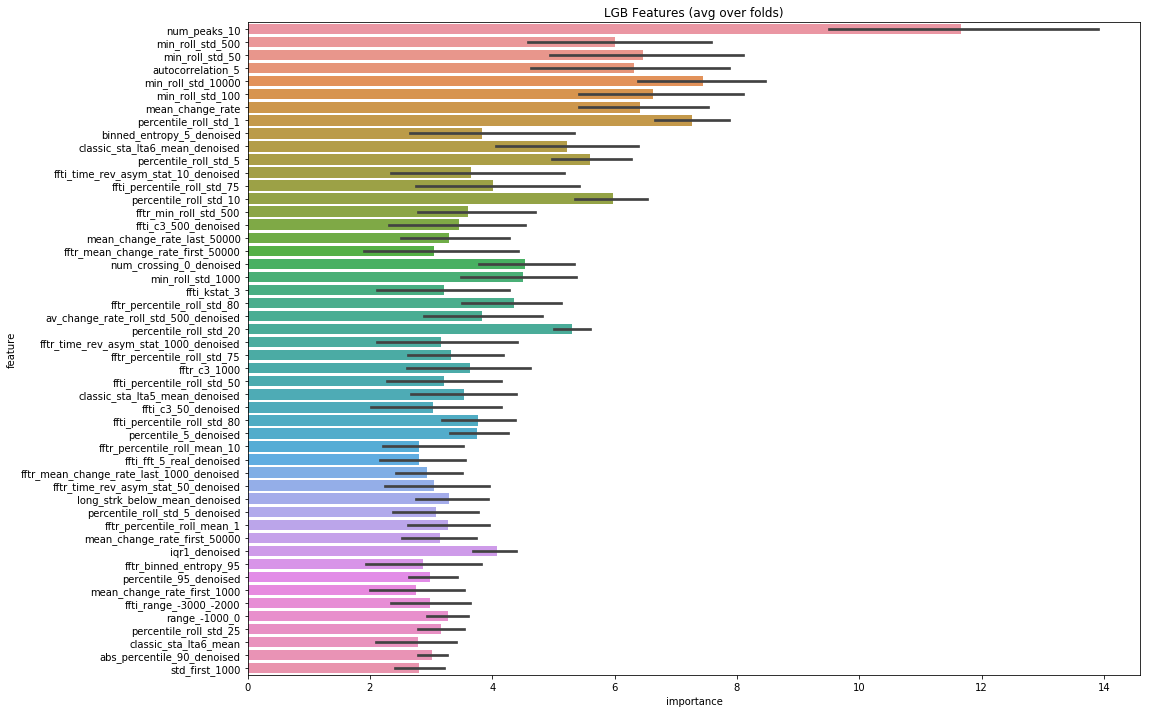

In [11]:
params = {'num_leaves': 32,
          'min_data_in_leaf': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'feature_fraction': 0.1
         }
result_dict_lgb = artgor_utils.train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb',
                                                                                  eval_metric='mae', plot_feature_importance=True)

In [12]:
submission['time_to_failure'] = result_dict_lgb['prediction']
submission.to_csv('submission_nn.csv')

## Model interpretation


### ELI5 and permutation importance
ELI5 is a package with provides explanations for ML models. It can do this not only for linear models, but also for tree based like Random Forest or lightgbm.

**Important notice**: running eli5 on all features takes a lot of time, so I run the cell below in `version 14` and printed the top-50 features. In the following versions I'll use these 50 columns and use eli5 to find top-40 of them so that it takes less time

In [13]:
top_columns = ['iqr1_denoised', 'percentile_5_denoised', 'abs_percentile_90_denoised', 'percentile_95_denoised', 'ave_roll_std_10', 'num_peaks_10', 'percentile_roll_std_20',
               'ratio_unique_values_denoised', 'fftr_percentile_roll_std_75_denoised', 'num_crossing_0_denoised', 'percentile_95', 'ffti_percentile_roll_std_75_denoised',
               'min_roll_std_10000', 'percentile_roll_std_1', 'percentile_roll_std_10', 'fftr_percentile_roll_std_70_denoised', 'ave_roll_std_50', 'ffti_percentile_roll_std_70_denoised',
               'exp_Moving_std_300_mean_denoised', 'ffti_percentile_roll_std_30_denoised', 'mean_change_rate', 'percentile_roll_std_5', 'range_-1000_0', 'mad',
               'fftr_range_1000_2000_denoised', 'percentile_10_denoised', 'ffti_percentile_roll_std_80', 'percentile_roll_std_25', 'fftr_percentile_10_denoised',
               'ffti_range_-2000_-1000_denoised', 'autocorrelation_5', 'min_roll_std_100', 'fftr_percentile_roll_std_80', 'min_roll_std_500', 'min_roll_std_50', 'min_roll_std_1000',
               'ffti_percentile_20_denoised', 'iqr1', 'classic_sta_lta5_mean_denoised', 'classic_sta_lta6_mean_denoised', 'percentile_roll_std_10_denoised',
               'fftr_percentile_70_denoised', 'ffti_c3_50_denoised', 'ffti_percentile_roll_std_75', 'abs_percentile_90', 'range_0_1000', 'spkt_welch_density_50_denoised',
               'ffti_percentile_roll_std_40_denoised', 'ffti_range_-4000_-3000', 'mean_change_rate_last_50000']


X_train, X_valid, y_train, y_valid = train_test_split(X[top_columns], y, test_size=0.1)
model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1, verbose=-1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
        verbose=10000, early_stopping_rounds=200)

perm = eli5.sklearn.PermutationImportance(model, random_state=1).fit(X_train, y_train)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[880]	training's l1: 1.64187	valid_1's l1: 2.10724


In [14]:
eli5.show_weights(perm, top=50, feature_names=top_columns)

Weight,Feature
0.0558 ± 0.0033,num_crossing_0_denoised
0.0315 ± 0.0042,num_peaks_10
0.0185 ± 0.0011,percentile_roll_std_5
0.0179 ± 0.0024,abs_percentile_90_denoised
0.0175 ± 0.0016,percentile_roll_std_10
0.0169 ± 0.0044,percentile_95_denoised
0.0166 ± 0.0013,min_roll_std_500
0.0156 ± 0.0006,percentile_roll_std_1
0.0139 ± 0.0021,percentile_5_denoised
0.0136 ± 0.0017,min_roll_std_50


Fold 1 started at Sun May 12 17:01:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[581]	training's l1: 1.7742	valid_1's l1: 2.16578
Fold 2 started at Sun May 12 17:01:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[984]	training's l1: 1.63933	valid_1's l1: 2.0647
Fold 3 started at Sun May 12 17:01:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1010]	training's l1: 1.62682	valid_1's l1: 2.05435
Fold 4 started at Sun May 12 17:01:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[747]	training's l1: 1.72375	valid_1's l1: 2.02219
Fold 5 started at Sun May 12 17:01:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[972]	training's l1: 1.62614	valid_1's l1: 2.21667
Fold 6 started at Sun May 12 17:01:53 201

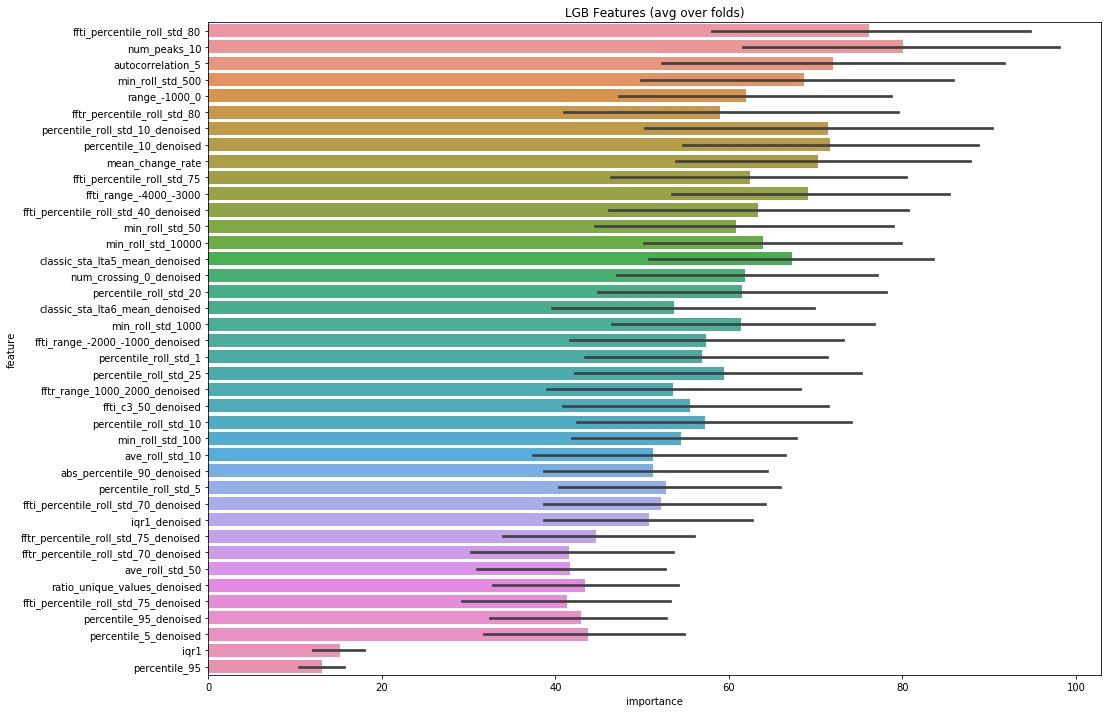

In [15]:
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:40]
result_dict_lgb = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True, columns=top_features)

In [16]:
submission['time_to_failure'] = result_dict_lgb['prediction']
submission.to_csv('submission_eli5.csv')

## Feature selection

Here I try various approaches to feature selection.

**Important notice**: running feature selection on all features takes a lot of time, so I'll run some of feature selection methods and print the result, which I'll use in the following versions of the kernel, so that I can explore more approaches.

In [17]:
params = {'num_leaves': 32,
          'min_child_samples': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "subsample_freq": 5,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'colsample_bytree': 1.0
         }

### SelectPercentile

**Important notice**:  I run the cell below in `version 14` and printed the scores_dict. In the following versions I'll use `scores_dict` and plot the results instead of running feature selection each time

In [18]:
# %%time
# scores_dict = {'f_classif': [], 'mutual_info_classif': [], 'n_features': []}
# for i in range(5, 105, 5):
#     print(i)
#     s1 = SelectPercentile(f_classif, percentile=i)
#     X_train1 = s1.fit_transform(X, y.values.astype(int))
#     X_test1 = s1.transform(X_test)
#     result_dict_lgb = artgor_utils.train_model_regression(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['f_classif'].append(np.mean(result_dict_lgb['scores']))
    
#     s2 = SelectPercentile(mutual_info_classif, percentile=i)
#     X_train1 = s2.fit_transform(X, y.values.astype(int))
#     X_test1 = s2.transform(X_test)
#     result_dict_lgb = artgor_utils.train_model_regression(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['mutual_info_classif'].append(np.mean(result_dict_lgb['scores']))
    
#     scores_dict['n_features'].append(X_train1.shape[1])

In [19]:
scores_dict = {'f_classif': [2.0746468465171377, 2.0753843541953687, 2.062191535440333, 2.0654327826583034, 2.0643551320704936, 2.0617560048382675,
                             2.061565197738015, 2.0598878198917494, 2.0654865223333143, 2.0632788555735777, 2.058002635080971, 2.051075689018734,
                             2.0472543961304583, 2.052401474353084, 2.055924154798443, 2.0561794619762352, 2.0549680611994963, 2.057123777802326,
                             2.0591868861136904, 2.0577745274024553],
               'mutual_info_classif': [2.0866763775014006, 2.0745431497064324, 2.0564324832516427, 2.060125564781158, 2.067334544167612, 2.0665943783246448,
                                       2.063891669849029, 2.070194051004794, 2.0667490707700447, 2.0681653852378354, 2.0592743636982345, 2.061260741522344,
                                       2.05680667824411, 2.0565047875243003, 2.058252567141659, 2.0554927194831922, 2.0562776429736873, 2.0618179277444084,
                                       2.06364125584214, 2.0577745274024553],
               'n_features': [98, 196, 294, 392, 490, 588, 685, 783, 881, 979, 1077, 1175, 1273, 1370, 1468, 1566, 1664, 1762, 1860, 1958]}

In [20]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'], value_vars=['mutual_info_classif', 'f_classif'], var_name='metric', value_name='mae')
max_value = scores_df['mae'].max() * 1.05
min_value = scores_df['mae'].min() * 0.95
artgor_utils.render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by SelectPercentile vs CV'
).interactive())

### SelectKBest

**Important notice**:  I run the cell below in `version 14` and printed the scores_dict. In the following versions I'll use `scores_dict` and plot the results instead of running feature selection each time

In [21]:
# %%time
# scores_dict = {'f_classif': [], 'mutual_info_classif': [], 'n_features': []}
# for i in np.arange(10, 1958, 100):
#     print(i)
#     s1 = SelectKBest(f_classif, k=i)
#     X_train1 = s1.fit_transform(X, y.values.astype(int))
#     X_test1 = s1.transform(X_test)
#     result_dict_lgb = artgor_utils.train_model_regression(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['f_classif'].append(np.mean(result_dict_lgb['scores']))
    
#     s2 = SelectKBest(mutual_info_classif, k=i)
#     X_train1 = s2.fit_transform(X, y.values.astype(int))
#     X_test1 = s2.transform(X_test)
#     result_dict_lgb = artgor_utils.train_model_regression(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['mutual_info_classif'].append(np.mean(result_dict_lgb['scores']))
    
#     scores_dict['n_features'].append(X_train1.shape[1])

In [22]:
scores_dict = {'f_classif': [2.1495892622081354, 2.0778182269587147, 2.0716153738740006, 2.06152950679902, 2.0645162758752553, 2.0627705797004032, 2.0610992303725157,
                             2.057762113735462, 2.0618360883613627, 2.0603197111525984, 2.06081274633874, 2.0580767195278056, 2.0527646572747127, 2.0498353445032533,
                             2.052442594925, 2.0564456881902133, 2.0582284644115365, 2.0558612960548635, 2.0580900016350094, 2.058218782401599],
               'mutual_info_classif': [2.1235703196243687, 2.084958198672301, 2.0596822478390955, 2.053305869981444, 2.063468853227225, 2.0674399950434323, 2.0658618511287874,
                                       2.063003703200445, 2.0653174905858664, 2.0644340327023656, 2.0748993062333523, 2.0587602096358113, 2.0601495560836076, 2.0559629138548603,
                                       2.0553852701221134, 2.058022171415446, 2.060755947658241, 2.057916705462307, 2.056245795262636, 2.0580691870837056],
               'n_features': [10, 110, 210, 310, 410, 510, 610, 710, 810, 910, 1010, 1110, 1210, 1310, 1410, 1510, 1610, 1710, 1810, 1910]}

In [23]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'], value_vars=['mutual_info_classif', 'f_classif'], var_name='metric', value_name='mae')
max_value = scores_df['mae'].max() * 1.05
min_value = scores_df['mae'].min() * 0.95
artgor_utils.render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by SelectKBest vs CV'
).interactive())

### Dropping highly correlated features

Due to the huge number of features there are certainly some highly correlated features, let's try droping them!

Fold 1 started at Sun May 12 17:02:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[485]	training's l1: 1.28874	valid_1's l1: 2.16307
Fold 2 started at Sun May 12 17:03:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[608]	training's l1: 1.16818	valid_1's l1: 1.96785
Fold 3 started at Sun May 12 17:04:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[699]	training's l1: 1.08734	valid_1's l1: 2.00079
Fold 4 started at Sun May 12 17:05:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[361]	training's l1: 1.45199	valid_1's l1: 1.99268
Fold 5 started at Sun May 12 17:06:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[380]	training's l1: 1.41295	valid_1's l1: 2.243
Fold 6 started at Sun May 12 17:06:57 2019

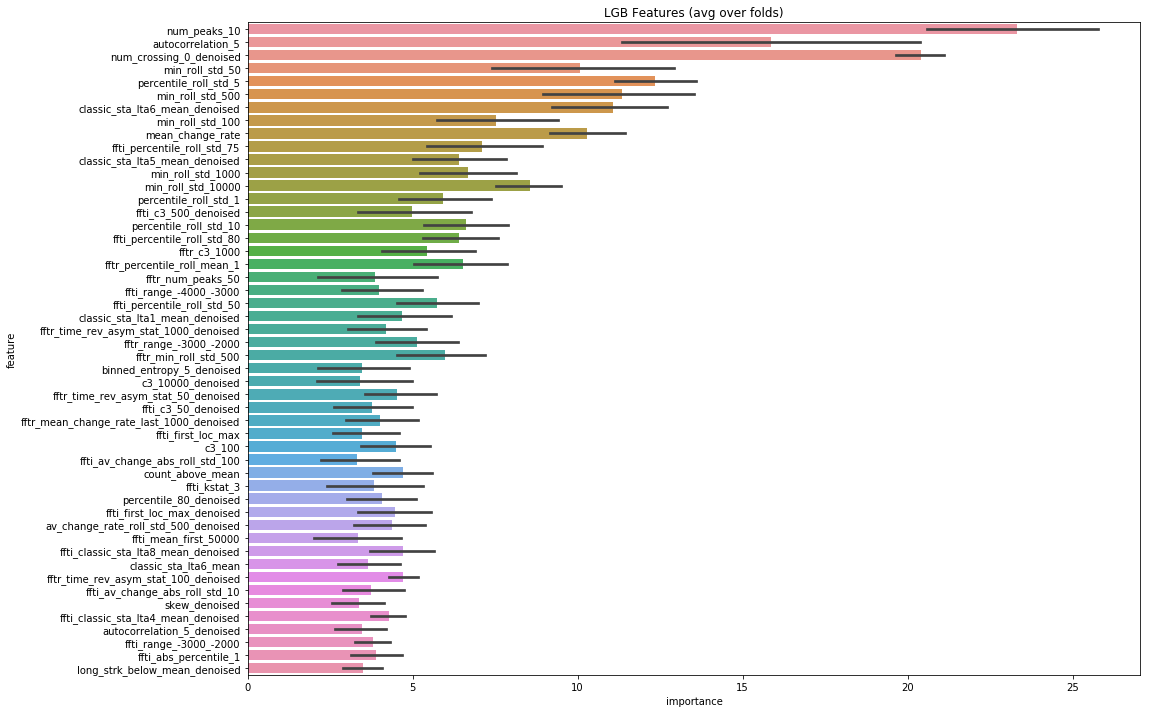

In [24]:
# https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
X = X.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)
result_dict_lgb_lgb = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [25]:
submission['time_to_failure'] = result_dict_lgb['prediction']
submission.to_csv('submission_no_corr.csv')

**Important**: from now I'll use the reduced dataset - without highly correlated features.

### RFE


**Important notice**:  I run the cell below in `version 18` and printed the scores_dict. In the following versions I'll use `scores_dict` and plot the results instead of running feature selection each time

In [26]:
# %%time
# scores_dict = {'rfe_score': [], 'n_features': []}
# for i in np.arange(10, 1958, 100)[:3]:
#     print(i)
#     s1 = RFE(model, i, step=100)
#     X_train1 = s1.fit_transform(X, y.values.astype(int))
#     X_test1 = s1.transform(X_test)
#     result_dict_lgb = artgor_utils.train_model_regression(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['rfe_score'].append(np.mean(result_dict_lgb['scores']))
    
#     scores_dict['n_features'].append(X_train1.shape[1])

In [27]:
scores_dict = {'rfe_score': [2.103586938061856, 2.052535910798748, 2.053228199447811], 'n_features': [10, 110, 210]}

In [28]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'], value_vars=['rfe_score'], var_name='metric', value_name='mae')
max_value = scores_df['mae'].max() * 1.05
min_value = scores_df['mae'].min() * 0.95
artgor_utils.render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by RFE vs CV'
).interactive())

## Model comparison

In this section I'll try variuos sklearn models and compair their score. Running GridSearchCV each time is too long, so I'll run it once for each model and use optimal parameters.

In [29]:
%%time
rfr = RandomForestRegressor()

# parameter_grid = {'n_estimators': [50, 60],
#                   'max_depth': [5, 10]
#                  }

# grid_search = GridSearchCV(rfr, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
# grid_search.fit(X, y)
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))
# rfr = RandomForestRegressor(**grid_search.best_params_)
rfr = RandomForestRegressor(n_estimators=50, max_depth=5)
result_dict_rfr = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=rfr)
# print(scores_rfr)

Fold 1 started at Sun May 12 17:10:24 2019
Fold 0. mae: 2.1852.

Fold 2 started at Sun May 12 17:11:12 2019
Fold 1. mae: 2.1103.

Fold 3 started at Sun May 12 17:12:00 2019
Fold 2. mae: 2.1026.

Fold 4 started at Sun May 12 17:12:49 2019
Fold 3. mae: 2.0677.

Fold 5 started at Sun May 12 17:13:37 2019
Fold 4. mae: 2.2516.

Fold 6 started at Sun May 12 17:14:25 2019
Fold 5. mae: 2.1106.

Fold 7 started at Sun May 12 17:15:14 2019
Fold 6. mae: 2.0243.

Fold 8 started at Sun May 12 17:16:03 2019
Fold 7. mae: 1.9783.

Fold 9 started at Sun May 12 17:16:50 2019
Fold 8. mae: 2.0145.

Fold 10 started at Sun May 12 17:17:39 2019
Fold 9. mae: 2.1834.

CV mean score: 2.1028, std: 0.0814.
CPU times: user 8min 1s, sys: 1.28 s, total: 8min 3s
Wall time: 8min 3s


In [30]:
%%time
linreg = linear_model.LinearRegression(normalize=False, copy_X=True, n_jobs=-1)

result_dict_linreg = artgor_utils.train_model_regression(X, X_test, y, params=None, folds=folds, model_type='sklearn', model=linreg)
# print(scores_linreg)

Fold 1 started at Sun May 12 17:18:27 2019
Fold 0. mae: 5.0844.

Fold 2 started at Sun May 12 17:18:28 2019
Fold 1. mae: 2.7188.

Fold 3 started at Sun May 12 17:18:29 2019
Fold 2. mae: 5.3980.

Fold 4 started at Sun May 12 17:18:30 2019
Fold 3. mae: 13.5369.

Fold 5 started at Sun May 12 17:18:31 2019
Fold 4. mae: 3.6393.

Fold 6 started at Sun May 12 17:18:32 2019
Fold 5. mae: 4.6337.

Fold 7 started at Sun May 12 17:18:33 2019
Fold 6. mae: 3.0735.

Fold 8 started at Sun May 12 17:18:34 2019
Fold 7. mae: 2.8634.

Fold 9 started at Sun May 12 17:18:35 2019
Fold 8. mae: 7.3932.

Fold 10 started at Sun May 12 17:18:36 2019
Fold 9. mae: 2.5965.

CV mean score: 5.0938, std: 3.1611.
CPU times: user 13.8 s, sys: 7.01 s, total: 20.8 s
Wall time: 9.99 s


In [31]:
%%time
ridge = linear_model.Ridge(normalize=True)

parameter_grid = {'alpha': [0.1, 1.0, 10.0]}

grid_search = GridSearchCV(ridge, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
ridge = linear_model.Ridge(**grid_search.best_params_, normalize=True)
result_dict_ridge = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=ridge)
# print(scores_ridge)

Best score: -2.1473301262700355
Best parameters: {'alpha': 1.0}
Fold 1 started at Sun May 12 17:18:57 2019
Fold 0. mae: 2.2310.

Fold 2 started at Sun May 12 17:18:57 2019
Fold 1. mae: 2.0909.

Fold 3 started at Sun May 12 17:18:58 2019
Fold 2. mae: 2.1735.

Fold 4 started at Sun May 12 17:18:59 2019
Fold 3. mae: 2.0831.

Fold 5 started at Sun May 12 17:19:00 2019
Fold 4. mae: 2.3161.

Fold 6 started at Sun May 12 17:19:00 2019
Fold 5. mae: 2.0915.

Fold 7 started at Sun May 12 17:19:01 2019
Fold 6. mae: 2.0370.

Fold 8 started at Sun May 12 17:19:02 2019
Fold 7. mae: 1.9966.

Fold 9 started at Sun May 12 17:19:02 2019
Fold 8. mae: 2.1002.

Fold 10 started at Sun May 12 17:19:03 2019
Fold 9. mae: 2.3534.

CV mean score: 2.1473, std: 0.1123.
CPU times: user 10.9 s, sys: 9.4 s, total: 20.3 s
Wall time: 27.1 s


In [32]:
%%time
knn = neighbors.KNeighborsRegressor()

parameter_grid = {'n_neighbors': [50, 100]}

grid_search = GridSearchCV(knn, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
knn = neighbors.KNeighborsRegressor(**grid_search.best_params_)
result_dict_knn = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=knn)

Best score: -2.388387466100546
Best parameters: {'n_neighbors': 100}
Fold 1 started at Sun May 12 17:19:27 2019
Fold 0. mae: 2.4862.

Fold 2 started at Sun May 12 17:19:29 2019
Fold 1. mae: 2.3872.

Fold 3 started at Sun May 12 17:19:32 2019
Fold 2. mae: 2.3558.

Fold 4 started at Sun May 12 17:19:34 2019
Fold 3. mae: 2.3575.

Fold 5 started at Sun May 12 17:19:37 2019
Fold 4. mae: 2.5481.

Fold 6 started at Sun May 12 17:19:39 2019
Fold 5. mae: 2.3763.

Fold 7 started at Sun May 12 17:19:42 2019
Fold 6. mae: 2.2831.

Fold 8 started at Sun May 12 17:19:44 2019
Fold 7. mae: 2.3108.

Fold 9 started at Sun May 12 17:19:46 2019
Fold 8. mae: 2.3851.

Fold 10 started at Sun May 12 17:19:49 2019
Fold 9. mae: 2.3938.

CV mean score: 2.3884, std: 0.0737.
CPU times: user 24.5 s, sys: 1.34 s, total: 25.9 s
Wall time: 47.5 s


In [33]:
%%time
lasso = linear_model.Lasso(normalize=True)

parameter_grid = {'alpha': [0.1, 1.0, 10.0]}

grid_search = GridSearchCV(lasso, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
lasso = linear_model.Lasso(**grid_search.best_params_, normalize=True)
result_dict_lasso = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=lasso)

Best score: -3.0490239593158237
Best parameters: {'alpha': 0.1}
Fold 1 started at Sun May 12 17:20:04 2019
Fold 0. mae: 3.2543.

Fold 2 started at Sun May 12 17:20:05 2019
Fold 1. mae: 3.0067.

Fold 3 started at Sun May 12 17:20:06 2019
Fold 2. mae: 3.1291.

Fold 4 started at Sun May 12 17:20:06 2019
Fold 3. mae: 3.0763.

Fold 5 started at Sun May 12 17:20:07 2019
Fold 4. mae: 3.1186.

Fold 6 started at Sun May 12 17:20:08 2019
Fold 5. mae: 2.9368.

Fold 7 started at Sun May 12 17:20:09 2019
Fold 6. mae: 2.9499.

Fold 8 started at Sun May 12 17:20:10 2019
Fold 7. mae: 3.0007.

Fold 9 started at Sun May 12 17:20:10 2019
Fold 8. mae: 2.9846.

Fold 10 started at Sun May 12 17:20:11 2019
Fold 9. mae: 3.0326.

CV mean score: 3.0490, std: 0.0922.
CPU times: user 8.1 s, sys: 7.42 s, total: 15.5 s
Wall time: 20.6 s


In [34]:
%%time
etr = ExtraTreesRegressor()

# parameter_grid = {'n_estimators': [500, 1000],
#                   'max_depth': [5, 10, 20]
#                  }

# grid_search = GridSearchCV(rfr, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
# grid_search.fit(X, y)
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))
# etr = ExtraTreesRegressor(**grid_search.best_params_)
etr = ExtraTreesRegressor(n_estimators=1000, max_depth=10)
result_dict_etr = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=etr)

Fold 1 started at Sun May 12 17:20:12 2019
Fold 0. mae: 2.1638.

Fold 2 started at Sun May 12 17:25:05 2019
Fold 1. mae: 2.1189.

Fold 3 started at Sun May 12 17:30:04 2019
Fold 2. mae: 2.0692.

Fold 4 started at Sun May 12 17:35:00 2019
Fold 3. mae: 2.0744.

Fold 5 started at Sun May 12 17:40:12 2019
Fold 4. mae: 2.2380.

Fold 6 started at Sun May 12 17:45:16 2019
Fold 5. mae: 2.0837.

Fold 7 started at Sun May 12 17:50:11 2019
Fold 6. mae: 2.0242.

Fold 8 started at Sun May 12 17:55:03 2019
Fold 7. mae: 1.9634.

Fold 9 started at Sun May 12 17:59:52 2019
Fold 8. mae: 1.9762.

Fold 10 started at Sun May 12 18:04:43 2019
Fold 9. mae: 2.2043.

CV mean score: 2.0916, std: 0.0868.
CPU times: user 49min 23s, sys: 2.09 s, total: 49min 25s
Wall time: 49min 25s


In [35]:
%%time
adr = AdaBoostRegressor()

parameter_grid = {'n_estimators': [10, 50],
                 }

grid_search = GridSearchCV(adr, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
adr = AdaBoostRegressor(**grid_search.best_params_)
result_dict_adr = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=adr)

Best score: -2.209341721647718
Best parameters: {'n_estimators': 10}
Fold 1 started at Sun May 12 18:13:00 2019
Fold 0. mae: 2.3070.

Fold 2 started at Sun May 12 18:13:11 2019
Fold 1. mae: 2.2239.

Fold 3 started at Sun May 12 18:13:21 2019
Fold 2. mae: 2.2360.

Fold 4 started at Sun May 12 18:13:32 2019
Fold 3. mae: 2.1560.

Fold 5 started at Sun May 12 18:13:42 2019
Fold 4. mae: 2.3552.

Fold 6 started at Sun May 12 18:13:52 2019
Fold 5. mae: 2.1975.

Fold 7 started at Sun May 12 18:14:02 2019
Fold 6. mae: 2.0924.

Fold 8 started at Sun May 12 18:14:13 2019
Fold 7. mae: 2.0657.

Fold 9 started at Sun May 12 18:14:23 2019
Fold 8. mae: 2.1975.

Fold 10 started at Sun May 12 18:14:34 2019
Fold 9. mae: 2.3161.

CV mean score: 2.2147, std: 0.0896.
CPU times: user 1min 54s, sys: 1.36 s, total: 1min 55s
Wall time: 5min 6s


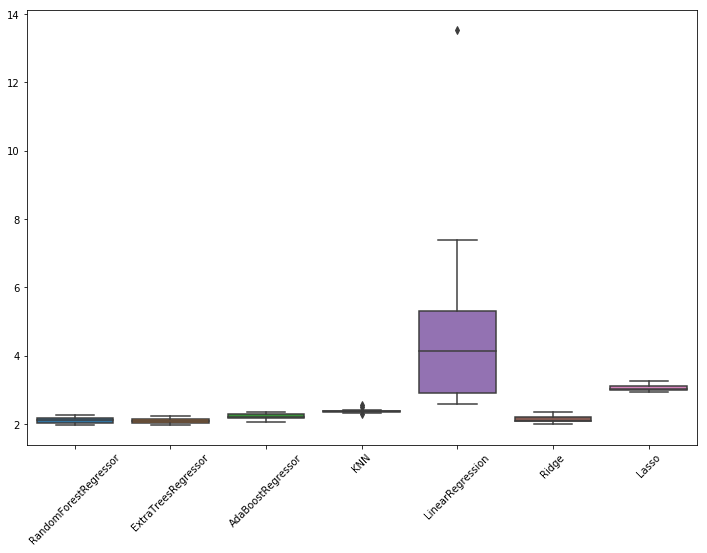

In [36]:
plt.figure(figsize=(12, 8));
scores_df = pd.DataFrame({'RandomForestRegressor': result_dict_rfr['scores']})
scores_df['ExtraTreesRegressor'] = result_dict_etr['scores']
scores_df['AdaBoostRegressor'] = result_dict_adr['scores']
scores_df['KNN'] = result_dict_knn['scores']
scores_df['LinearRegression'] = result_dict_linreg['scores']
scores_df['Ridge'] = result_dict_ridge['scores']
scores_df['Lasso'] = result_dict_lasso['scores']

sns.boxplot(data=scores_df);
plt.xticks(rotation=45);

## Blending

Let's try training and blending several models.

Fold 1 started at Sun May 12 18:14:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[500]	training's l1: 1.35458	valid_1's l1: 2.15266
Fold 2 started at Sun May 12 18:14:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[843]	training's l1: 1.06781	valid_1's l1: 1.98751
Fold 3 started at Sun May 12 18:15:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[840]	training's l1: 1.06694	valid_1's l1: 2.00041
Fold 4 started at Sun May 12 18:15:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[496]	training's l1: 1.37046	valid_1's l1: 1.99542
Fold 5 started at Sun May 12 18:15:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[398]	training's l1: 1.46321	valid_1's l1: 2.22161
Fold 6 started at Sun May 12 18:16:05 20

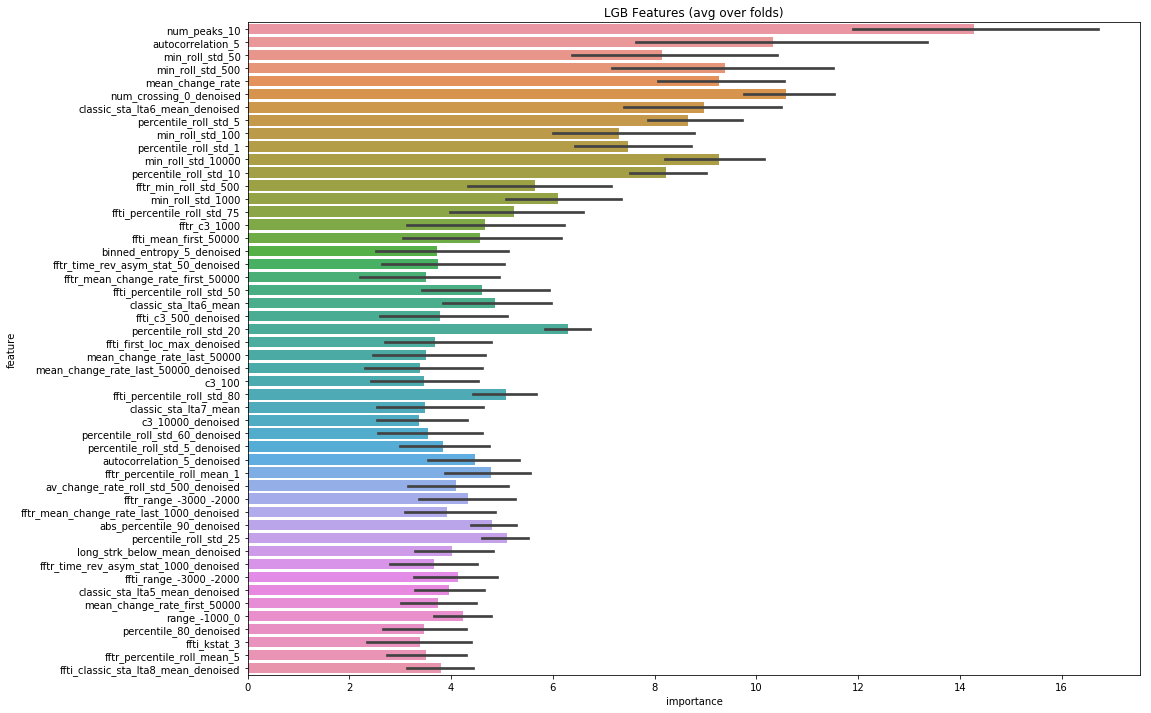

In [37]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "subsample_freq": 5,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'colsample_bytree': 0.2
         }
result_dict_lgb = artgor_utils.train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb',
                                                                                  eval_metric='mae', plot_feature_importance=True)

In [38]:
xgb_params = {'eta': 0.03,
              'max_depth': 9,
              'subsample': 0.85,
              'colsample_bytree': 0.3,
              'objective': 'reg:linear',
              'eval_metric': 'mae',
              'silent': True,
              'nthread': -1}
result_dict_xgb = artgor_utils.train_model_regression(X=X, X_test=X_test, y=y, params=xgb_params, folds=folds, model_type='xgb')

Fold 1 started at Sun May 12 18:17:05 2019
[0]	train-mae:5.02425	valid_data-mae:5.413
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[160]	train-mae:0.405357	valid_data-mae:2.18417

Fold 2 started at Sun May 12 18:18:33 2019
[0]	train-mae:5.0739	valid_data-mae:4.93723
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[75]	train-mae:0.953659	valid_data-mae:2.03278

Fold 3 started at Sun May 12 18:19:40 2019
[0]	train-mae:5.06433	valid_data-mae:5.04342
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[139]	train-mae:0.487576	valid_data-mae:2.08602

Fold 4 started at Sun May 12 18:21:02 2019
[0]	train-

In [39]:
submission['time_to_failure'] = (result_dict_lgb['prediction'] + result_dict_etr['prediction'] + result_dict_xgb['prediction']) / 3
print(submission.head())
submission.to_csv('blending.csv')

              time_to_failure
seg_id                       
seg_00030f  4.090013039246862
seg_0012b5  4.975362719294233
seg_00184e  5.770717335662693
seg_003339  8.485048442032031
seg_0042cc  6.987884642991566


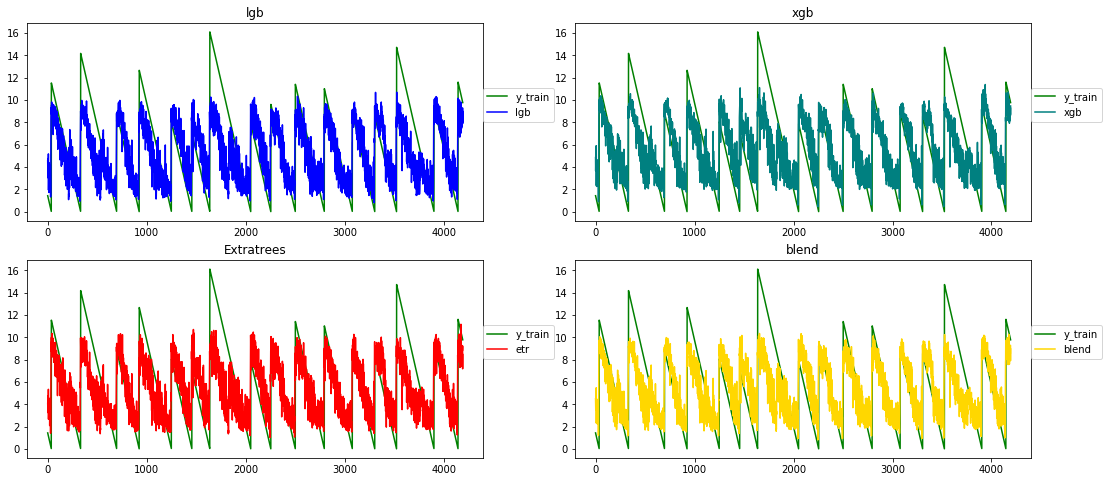

In [40]:
plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.plot(y, color='g', label='y_train')
plt.plot(result_dict_lgb['oof'], color='b', label='lgb')
plt.legend(loc=(1, 0.5));
plt.title('lgb');
plt.subplot(2, 2, 2)
plt.plot(y, color='g', label='y_train')
plt.plot(result_dict_etr['oof'], color='teal', label='xgb')
plt.legend(loc=(1, 0.5));
plt.title('xgb');
plt.subplot(2, 2, 3)
plt.plot(y, color='g', label='y_train')
plt.plot(result_dict_xgb['oof'], color='red', label='etr')
plt.legend(loc=(1, 0.5));
plt.title('Extratrees');
plt.subplot(2, 2, 4)
plt.plot(y, color='g', label='y_train')
plt.plot((result_dict_lgb['oof'] + result_dict_etr['oof'] + result_dict_xgb['oof']) / 3, color='gold', label='blend')
plt.legend(loc=(1, 0.5));
plt.title('blend');

## Stacking

In [41]:
train_stack = np.vstack([result_dict_rfr['oof'], result_dict_ridge['oof'], result_dict_knn['oof'], result_dict_lasso['oof'], result_dict_etr['oof'],
                         result_dict_adr['oof'], result_dict_lgb['oof'], result_dict_xgb['oof'], result_dict_etr['oof']]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['rfr', 'ridge', 'knn', 'lasso', 'etr', 'adr', 'lgb', 'xgb', 'etr'])

test_stack = np.vstack([result_dict_rfr['prediction'], result_dict_ridge['prediction'], result_dict_knn['prediction'], result_dict_lasso['prediction'], result_dict_etr['prediction'],
                        result_dict_adr['prediction'], result_dict_lgb['prediction'], result_dict_xgb['prediction'], result_dict_etr['prediction']]).transpose()
test_stack = pd.DataFrame(test_stack, columns=['rfr', 'ridge', 'knn', 'lasso', 'etr', 'adr', 'lgb', 'xgb', 'etr'])

In [42]:
params = {'num_leaves': 8,
         #'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 2,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
        # "lambda_l1": 0.2,
         "verbosity": -1}
result_dict_lgb_stack = artgor_utils.train_model_regression(X=train_stack, X_test=test_stack, y=y, params=params, folds=folds, model_type='lgb',
                                                                                  eval_metric='mae', plot_feature_importance=False,
                                                            columns=(list(train_stack.columns)))

Fold 1 started at Sun May 12 18:29:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[440]	training's rmse: 2.59795	training's l1: 2.02768	valid_1's rmse: 2.7757	valid_1's l1: 2.17805
Fold 2 started at Sun May 12 18:29:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[298]	training's rmse: 2.63101	training's l1: 2.05813	valid_1's rmse: 2.61591	valid_1's l1: 2.07605
Fold 3 started at Sun May 12 18:29:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[710]	training's rmse: 2.58797	training's l1: 2.02559	valid_1's rmse: 2.68223	valid_1's l1: 2.04106
Fold 4 started at Sun May 12 18:29:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[628]	training's rmse: 2.6016	training's l1: 2.02935	valid_1's rmse: 2.59358	valid_1's l1: 2.04332
Fold 5 started at Sun May 12 18:29:45 

In [43]:
submission['time_to_failure'] = result_dict_lgb_stack['prediction']
print(submission.head())
submission.to_csv('stacking.csv')

              time_to_failure
seg_id                       
seg_00030f  4.440638720637780
seg_0012b5  5.223449756439992
seg_00184e  6.108649491869405
seg_003339  8.811787910803968
seg_0042cc  7.240084107762415
